In [3]:
import sys
# sys.path.append('E:/Code/Attention-SNN/Att_Res_SNN')

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from simple_utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs
    )

from models import resnet_2

from datetime import datetime
import glob

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet_2.resnet34().to(device)
summary(model, input_size=(1, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Snn_Conv2d-1      [32, 2, 64, 128, 128]           3,136
      BatchNorm3d1-2      [32, 64, 1, 128, 128]             128
     batch_norm_2d-3      [32, 2, 64, 128, 128]               0
        mem_update-4      [32, 2, 64, 128, 128]               0
        Snn_Conv2d-5        [32, 2, 64, 64, 64]          36,864
      BatchNorm3d1-6        [32, 64, 1, 64, 64]             128
     batch_norm_2d-7        [32, 2, 64, 64, 64]               0
        mem_update-8        [32, 2, 64, 64, 64]               0
        Snn_Conv2d-9        [32, 2, 64, 64, 64]          36,864
     BatchNorm3d2-10        [32, 64, 1, 64, 64]             128
   batch_norm_2d1-11        [32, 2, 64, 64, 64]               0
AdaptiveAvgPool3d-12          [32, 64, 1, 1, 1]               0
           Conv3d-13           [32, 8, 1, 1, 1]             512
             ReLU-14           [32, 8, 

In [9]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3 # 1e-3 -> 1e-4 -> 5e-5 
Batch_size  = 32
num_epochs  = 10
num_workers = 4
IMAGE_HEIGHT = 256 # 256 -> 512 originally
IMAGE_WIDTH  = 256 # 256 -> 512 originally
PIN_MEMORY = True
LOAD_MODEL = True
CHECKPOINT_NAME = "Att_Res_SNN_checkpoint_78_2025-04-14_20-38-23.pth.tar"
IMG_DIR      =  "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_2_Brain_Tumor_Segmentation/images"
MASK_DIR     =  "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_2_Brain_Tumor_Segmentation/masks"
VAL_IMG_DIR  =  "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_2_Brain_Tumor_Segmentation/val_images"
VAL_MASK_DIR =  "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_2_Brain_Tumor_Segmentation/val_masks"

In [10]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    running_loss=0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        targets = targets.float().unsqueeze(1).to(device=Device) 

        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        
        running_loss+=loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_postfix(loss=loss.item())
        
    return running_loss/len(loader)

In [11]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = resnet_2.resnet34().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    train_losses=[]
    val_dice_scores=[]
    val_accs=[]

    if LOAD_MODEL:
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        check_accuracy(val_loader, model, device=Device)
        
    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":  optimizer.state_dict(),
        }
        checkpoint_filename = save_checkpoint(checkpoint)

        val_acc, val_dice = check_accuracy(val_loader, model, device=Device)

        train_losses.append(train_loss)
        val_accs.append(val_acc.cpu().item())
        val_dice_scores.append(val_dice.cpu().item())

        if epoch != num_epochs - 1:
            save_predictions_as_imgs(
                val_loader, 
                model, 
                checkpoint_filename=checkpoint_filename, 
                train_losses=train_losses,
                val_accs=val_accs,
                val_dice_scores=val_dice_scores,
                folder="Att_Res_SNN_saved_images/", 
                device=Device, 
                show_last_epoch=False,
            )
        else:
            save_predictions_as_imgs(
                val_loader, 
                model, 
                checkpoint_filename=checkpoint_filename, 
                train_losses=train_losses,
                val_accs=val_accs,
                val_dice_scores=val_dice_scores, 
                folder="Att_Res_SNN_saved_images/", 
                device=Device, 
                show_last_epoch=True,
            )

✅ Loaded checkpoint: Att_Res_SNN_checkpoint_78_2025-04-14_20-38-23.pth.tar
Got 29170114/29360128 with acc  99.35
Dice score: 0.8239731192588806


100%|██████████████████████████████████████████████| 82/82 [02:11<00:00,  1.60s/it, loss=0.0119]


✅ Checkpoint saved: Att_Res_SNN_checkpoint_79_2025-04-14_21-10-17.pth.tar
Got 29165905/29360128 with acc  99.34
Dice score: 0.8189891576766968


100%|██████████████████████████████████████████████| 82/82 [02:22<00:00,  1.73s/it, loss=0.0177]


✅ Checkpoint saved: Att_Res_SNN_checkpoint_80_2025-04-14_21-13-24.pth.tar
Got 29160141/29360128 with acc  99.32
Dice score: 0.803773045539856


100%|██████████████████████████████████████████████| 82/82 [02:24<00:00,  1.77s/it, loss=0.0123]


✅ Checkpoint saved: Att_Res_SNN_checkpoint_81_2025-04-14_21-16-37.pth.tar
Got 29161392/29360128 with acc  99.32
Dice score: 0.8140738010406494


100%|██████████████████████████████████████████████| 82/82 [02:25<00:00,  1.77s/it, loss=0.0139]


✅ Checkpoint saved: Att_Res_SNN_checkpoint_82_2025-04-14_21-19-52.pth.tar
Got 29162156/29360128 with acc  99.33
Dice score: 0.8160143494606018


100%|██████████████████████████████████████████████| 82/82 [02:25<00:00,  1.77s/it, loss=0.0155]


✅ Checkpoint saved: Att_Res_SNN_checkpoint_83_2025-04-14_21-23-04.pth.tar
Got 29166033/29360128 with acc  99.34
Dice score: 0.8158466219902039


100%|██████████████████████████████████████████████| 82/82 [02:13<00:00,  1.63s/it, loss=0.0182]


✅ Checkpoint saved: Att_Res_SNN_checkpoint_84_2025-04-14_21-26-03.pth.tar
Got 29150135/29360128 with acc  99.28
Dice score: 0.7986263036727905


100%|██████████████████████████████████████████████| 82/82 [02:24<00:00,  1.77s/it, loss=0.0146]


✅ Checkpoint saved: Att_Res_SNN_checkpoint_85_2025-04-14_21-29-04.pth.tar
Got 29154728/29360128 with acc  99.30
Dice score: 0.804416835308075


100%|██████████████████████████████████████████████| 82/82 [02:09<00:00,  1.58s/it, loss=0.0138]


✅ Checkpoint saved: Att_Res_SNN_checkpoint_86_2025-04-14_21-31-46.pth.tar
Got 29148051/29360128 with acc  99.28
Dice score: 0.7939116954803467


100%|██████████████████████████████████████████████| 82/82 [02:09<00:00,  1.58s/it, loss=0.0133]


✅ Checkpoint saved: Att_Res_SNN_checkpoint_87_2025-04-14_21-34-51.pth.tar
Got 29138153/29360128 with acc  99.24
Dice score: 0.7796165943145752


100%|██████████████████████████████████████████████| 82/82 [02:23<00:00,  1.75s/it, loss=0.0106]


✅ Checkpoint saved: Att_Res_SNN_checkpoint_88_2025-04-14_21-37-50.pth.tar
Got 29166809/29360128 with acc  99.34
Dice score: 0.817925751209259


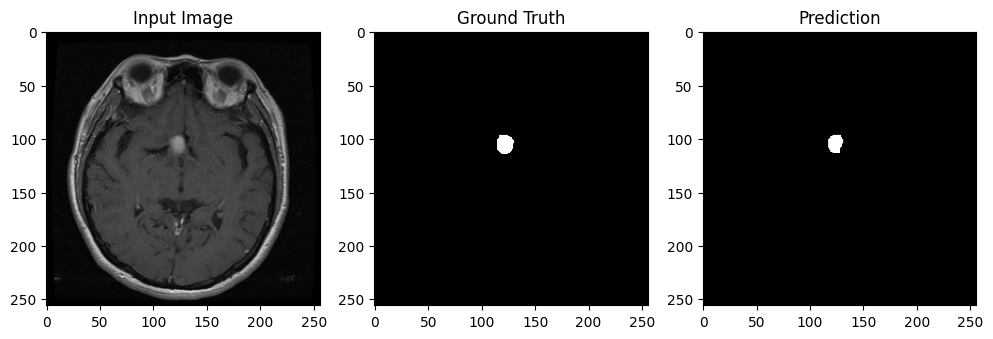

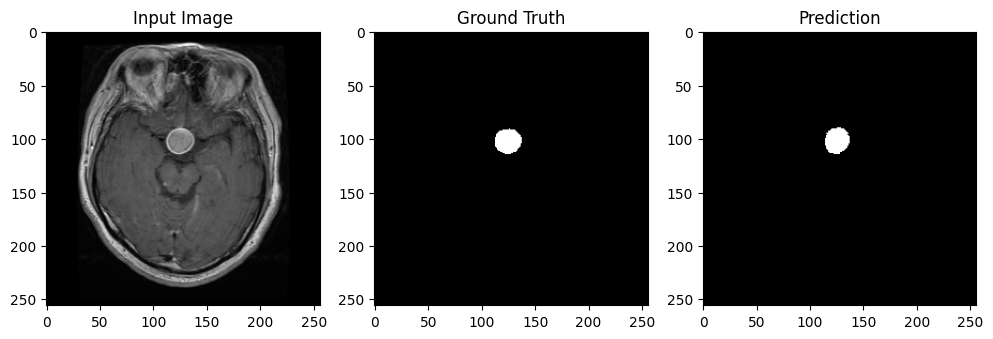

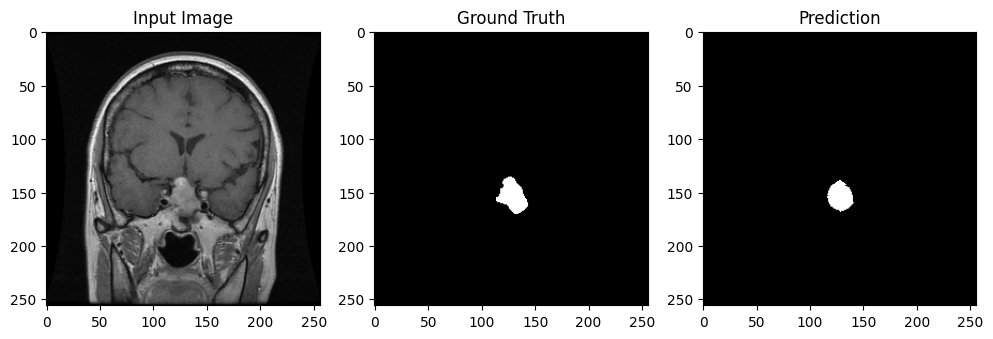

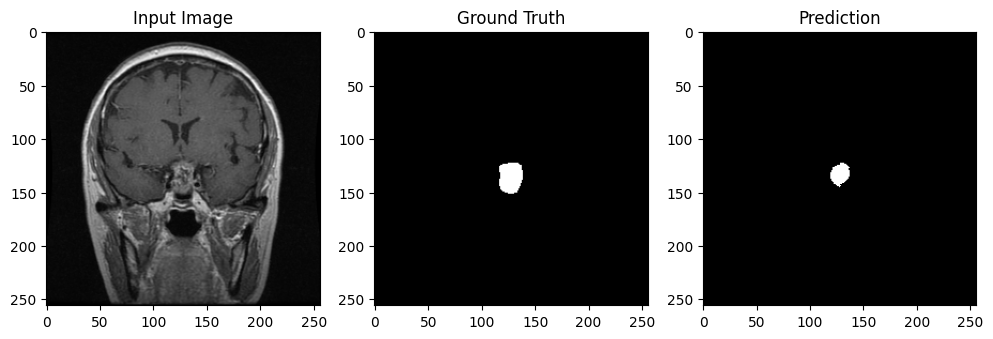

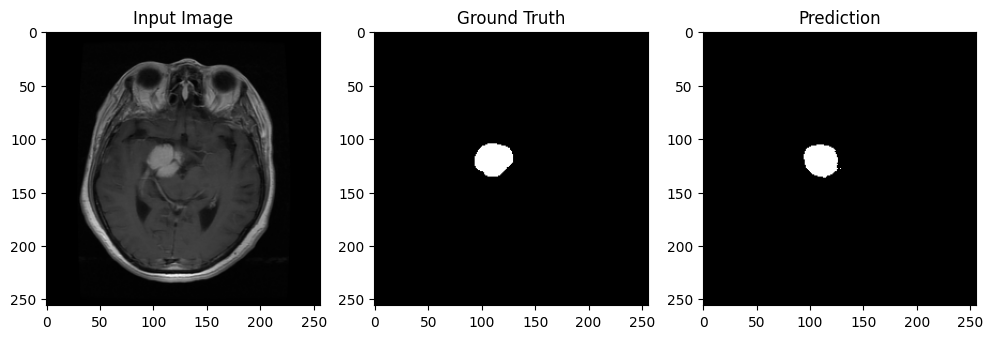

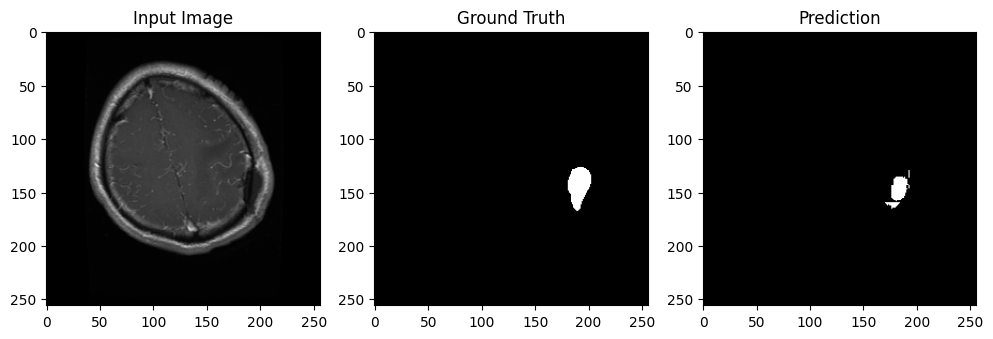

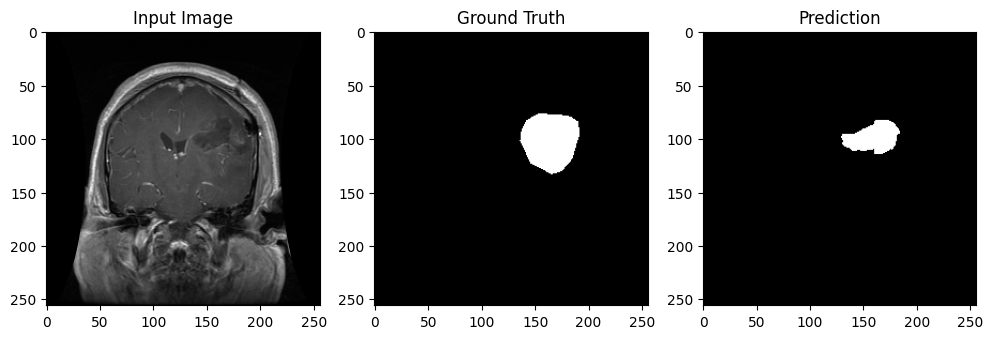

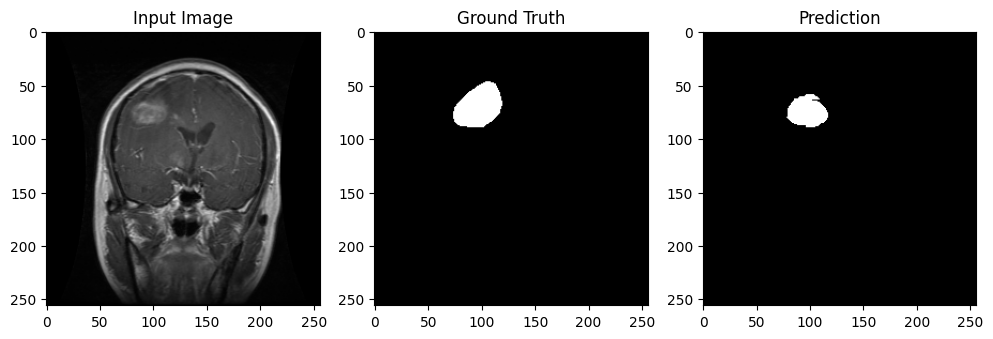

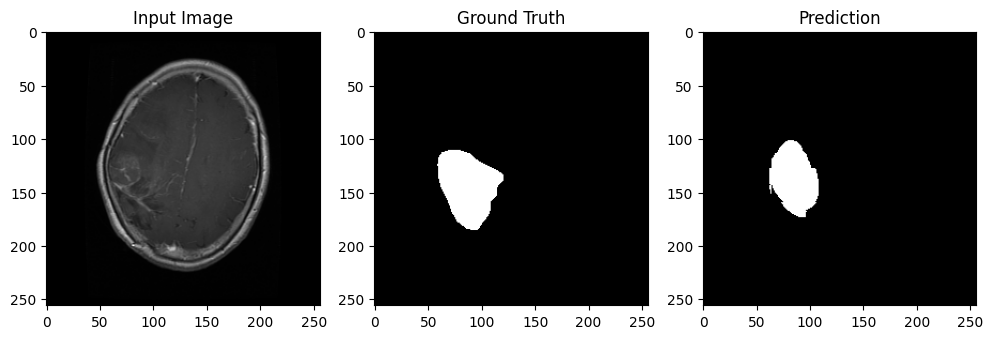

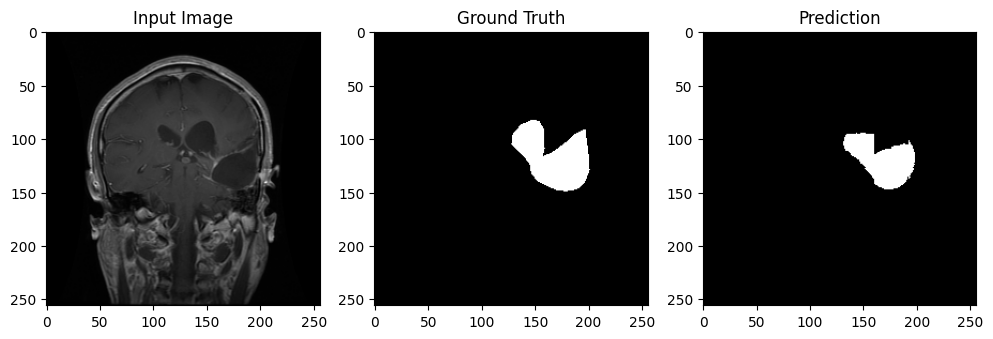

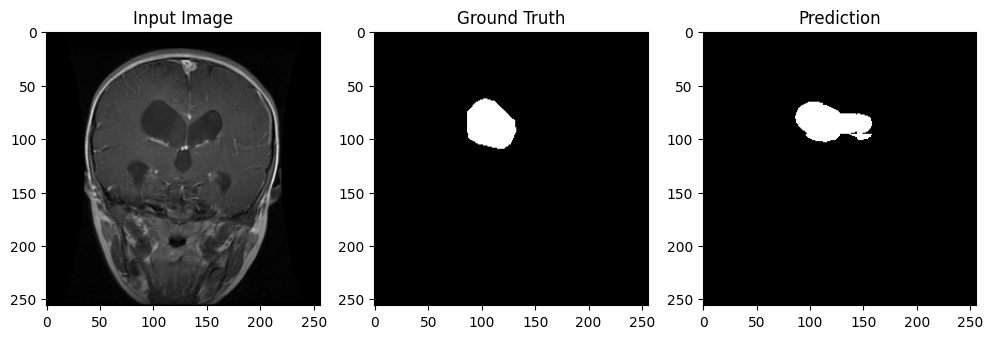

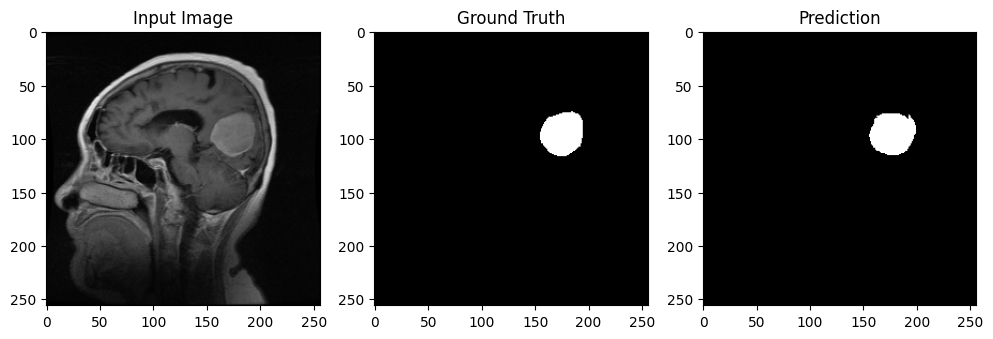

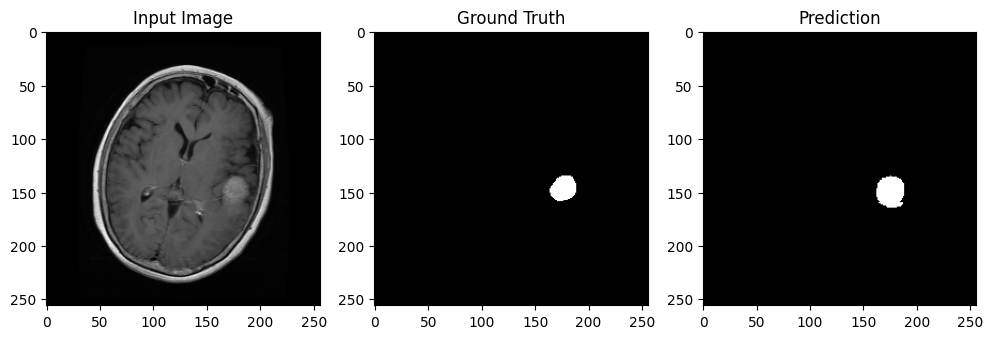

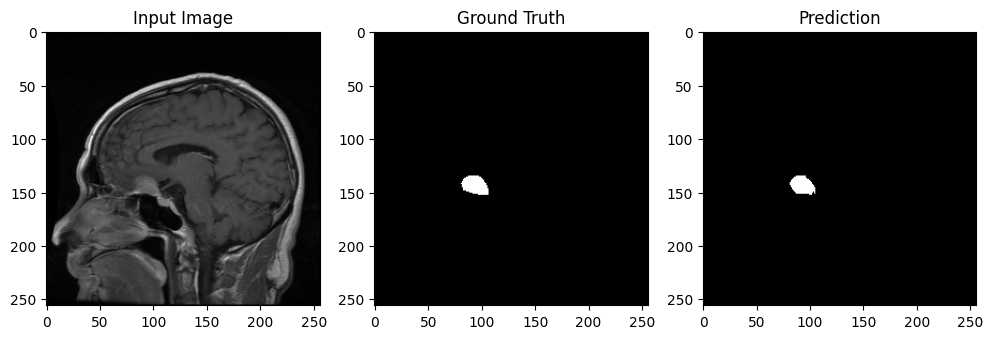

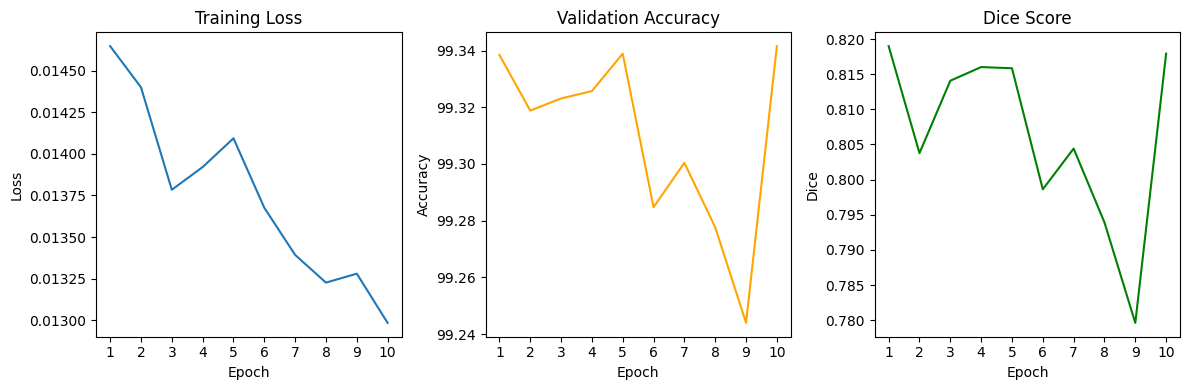

In [12]:
if __name__ == "__main__": 
    main()

## Grad-CAM

In [20]:
def load_and_preprocess_image(image_path):
    transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.0), std=(1.0), max_pixel_value=255.0),
    ToTensorV2(),
    ])
    image = Image.open(image_path).convert("L")
    image_rgb = Image.open(image_path).convert("RGB")
    processed = transform(image=np.array(image))
    input_tensor = processed['image'].unsqueeze(0)
    vis_image = np.array(image_rgb.resize((256, 256))) / 255.0
    return input_tensor, vis_image

def reshape_transform_csa(tensor):
    # If tensor shape is [B, C, T, H, W], convert to [B, C*T, H, W]
    if tensor.ndim == 5:
        B, C, T, H, W = tensor.size()
        return tensor.permute(0, 2, 1, 3, 4).reshape(B, T * C, H, W)
    elif tensor.ndim == 4:
        return tensor  # Already [B, C, H, W]
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

def generate_gradcam_grid(
        model,
        image_paths,
        mask_paths,
        target_layer,
        device="cuda",
        save_folder="./Att_Res_SNN_gradcam_results",
        grid_rows=3,
        grid_cols=6
    ):
    os.makedirs(save_folder, exist_ok=True)
    model.to(device).eval()

    # cam = GradCAM(model=model, target_layers=[target_layer])
    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform_csa)

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
    fig_idx = 0
    cam_idx = 0

    for idx in range(len(image_paths)):
        input_tensor, vis_image = load_and_preprocess_image(image_paths[idx])
        input_tensor = input_tensor.to(device)

        mask_tensor, _ = load_and_preprocess_image(mask_paths[idx])
        input_mask_tensor = mask_tensor.squeeze(0).cpu().numpy()

        targets = [SemanticSegmentationTarget(0, input_mask_tensor)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        # grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0]

        cam_image = show_cam_on_image(vis_image, grayscale_cam, use_rgb=True)

        row = fig_idx // grid_cols
        col = fig_idx % grid_cols

        if row < grid_rows:
            axes[row, col].imshow(cam_image)
            axes[row, col].axis("off")
            axes[row, col].set_title(f"Grad-CAM for {os.path.basename(image_paths[idx])}")

        fig_idx += 1

        # If we filled the grid (e.g., 18 images), save and reset
        if fig_idx == grid_rows * grid_cols or idx == len(image_paths) - 1:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
            save_path = os.path.join(save_folder, f"GradCAM_grid_{cam_idx}_{timestamp}.png")
            plt.tight_layout()
            plt.savefig(save_path)
            print(f"✅ Saved {save_path}")
            plt.close(fig)

            # Reset for next grid (if more images left)
            if idx < len(image_paths) - 1:
                fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
                fig_idx = 0
                cam_idx += 1


In [ ]:
# class TemporalCollapseWrapper(nn.Module):
#     def __init__(self, layer):
#         super(TemporalCollapseWrapper, self).__init__()
#         self.layer = layer

#     def forward(self, x):
#         output = self.layer(x)  # Output shape: [time_window, batch_size, channels, height, width]
#         if output is None:
#             raise ValueError("The output of the target layer is None. Check the model definition.")
#         output = output.mean(dim=0)  # Collapse temporal dimension (average over time)
#         return output  # Output shape: [batch_size, channels, height, width]
    
model = resnet_2.resnet34().to(device)
checkpoint = torch.load("E:/Code/Attention-SNN/Att_Res_SNN_checkpoints/Att_Res_SNN_checkpoint_40_2025-04-14_08-50-42.pth.tar", map_location="cuda")
model.load_state_dict(checkpoint["state_dict"])


# target_layer = model.conv5_x[-1].residual_function[-1].attention.ca.sharedMLP[0]
# target_layer = model.conv5_x[-1].residual_function[-1].attention.sa.conv
# target_layer = model.conv5_x[-1].residual_function[-1]
# target_layer = model.conv5_x[-1]

# target_layer = model.conv4_x[-1].residual_function[-1]
# target_layer = model.conv4_x[-1].residual_function[-1].attention.ca.sharedMLP[0]
target_layer = model.conv4_x[-1].residual_function[-1].attention.sa.conv



# target_layer = model.segmentation_head[0] 
# target_layer = model.segmentation_head[-1] 

# image_paths = sorted(glob.glob(os.path.join(VAL_IMG_DIR, "*.png")))
# mask_paths = sorted(glob.glob(os.path.join(VAL_MASK_DIR, "*.png")))

image_paths = [
    "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_2_Brain_Tumor_Segmentation/val_images/1.png"
]
mask_paths = [
    "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_2_Brain_Tumor_Segmentation/val_masks/1.png"
]

generate_gradcam_grid(model, image_paths, mask_paths, target_layer)

✅ Saved ./Att_Res_SNN_gradcam_results\GradCAM_grid_0_20250418-120138.png
